Modelar o ciclo de cogeração ilustrado abaixo. Permitir que o processo varie de 
0% (desligado) até 100% (completamente ligado).

![Ciclo](img/ciclo.jpeg "Ciclo")

Importando bibliotecas necessárias

In [84]:
from pandas import read_excel, DataFrame
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import State as st
from numpy import arange, absolute, nan, linspace
from sympy import symbols
from sympy.solvers.solveset import linsolve

In [85]:
df = read_excel('data.xlsx')
display(df.replace(nan, '-'))

,Temperatura [ºC],Pressão [kPa],Vazão [kg/s],Título [-]
0,485,6495,27.9,-
1,-,900,-,-
2,-,250,-,-
3,51,Saturação,-,-
4,51,Saturação,-,0.0
5,-,250,-,-
6,110,250,-,-
7,-,6495,27.9,-
8,110,250,-,-
9,-,900,-,-


Dados fornecidos

In [86]:
fluido = 'Water'
n_turb, n_pump = 0.85, 0.85
F_processo = 1

Inserindo temperatura de saturação na tabela e convertendo para K

In [87]:
T, c = [], 0

for i in df['Temperatura [ºC]']:
    c = c + 1
    try:
        if i == 'Saturação':
            T.insert(c-1, round(prop('T', 'P', df['Pressão [kPa]'][c-1], 'Q', 0, fluido), 2) )
        else:
            T.insert(c-1, i + 273.15)
    except ValueError or NameError:
        print(f'Sem informações de pressão no estado {c}')

Inserindo pressão de saturação na tabela 

In [88]:
P, c = [], 0
for i in df['Pressão [kPa]']:
    c = c + 1
    try:
        if i == 'Saturação':
            P.insert(c-1, round(prop('P', 'T', T[c-1], 'Q', 0, fluido)/10**3,2) )
        else:
            P.insert(c-1, i)
    except ValueError or NameError:
        print(f'Sem informações de temperatura no estado {c}')

Definindo valores de vazão e titulo a partir da tabela de dados

In [89]:
vazao = df['Vazão [kg/s]']
x = df['Título [-]']

## Definindo estados ##

$$ st: Estado $$

In [90]:
def estado(P=None, T=None, x=None, s=None, h=None):
    if x==None and s==None and h==None:
        return st(fluido, {'P': P, 'T': T})
    if T==None and s==None and h==None:
        return st(fluido, {'P': P, 'Q': x})
    if T==None and x==None and h==None:
        return st(fluido, {'P': P, 'S': s})
    if T==None and x==None and s==None:
        return st(fluido, {'P': P, 'H': h})
    if P==None and T==None and x==None and s==None and h==None:
        return print('Falta informações')

Definindo estados em função da pressão e temperatura com dados fornecidos

$$st: st(P, T)$$

In [91]:
st1 = estado(P=P[0], T=T[0])
st7 = estado(P=P[6], T=T[6])
st9 = estado(P=P[8], T=T[8])

Definindo estados em função da pressão e titulo com dados fornecidos

$$st: st(P, x)$$

In [92]:
st5 = estado(P=P[4], x=x[4])
st11 = estado(P=P[10], x=x[10])
st12 = estado(P=P[11], x=x[11])

Definindo estados a partir da equação de eficiência isentrópica para turbinas

$$ \eta_{turb} = \frac{h_{n-1} - h_{n}}{h_{n-1} - h_{ns}} $$

Estado 2

$$ st_{2s}: st_{2s}(P_{2}, S_{1}) $$
$$ h_{2} = h_{1} - \eta_{turb}(h_{1} - h_{2s}) $$
$$ st_{2}: st_{2}(P_{2}, h_{2}) $$

In [93]:
st2s = estado(P=P[1], s=st1.s)
h2 = st1.h - n_turb*(st1.h - st2s.h)
st2 = estado(P=P[1], h=h2)

Estado 3

$$ st_{3s}: st_{3s}(P_{3}, S_{2}) $$
$$ h_{3} = h_{2} - \eta_{turb}(h_{2} - h_{3s}) $$
$$ st_{3}: st_{2}(P_{3}, h_{3}) $$

In [94]:
st3s = estado(P=P[2], s=st2.s)
h3 = st2.h - n_turb*(st2.h - st3s.h)
st3 = estado(P=P[2], h=h3)

Estado 4

$$ st_{4s}: st_{4s}(P_{4}, S_{3}) $$
$$ h_{4} = h_{3} - \eta_{turb}(h_{3} - h_{4s}) $$
$$ st_{4}: st_{4}(P_{4}, h_{4}) $$

In [95]:
st4s = estado(P=P[3], s=st3.s)
h4 = st3.h - n_turb*(st3.h - st4s.h)
st4 = estado(P=P[3], h=h4)

Definindo estados a partir da equação de eficiência isentrópica para bombas

$$ \eta_{pump} = \frac{h_{ns} - h_{n-1}}{h_{n} - h_{n-1}} $$

Estado 6

$$ st_{6s}: st_{6s}(P_{6}, S_{5}) $$
$$ h_{6} = h_{5} + \frac{h_{6s} - h_{5}}{\eta_{pump}} $$
$$ st_{6}: st_{6}(P_{6}, h_{6}) $$

In [96]:
st6s = estado(P=P[5], s=st5.s)
h6 = st5.h + (st6s.h - st5.h)/n_pump
st6 = estado(P=P[5], h=h6)

Estado 8

$$ st_{8s}: st_{8s}(P_{8}, S_{7}) $$
$$ h_{8} = h_{7} + \frac{h_{8s} - h_{7}}{\eta_{pump}} $$
$$ st_{8}: st_{8}(P_{8}, h_{8}) $$

In [97]:
st8s = estado(P=P[7], s=st7.s)
h8 = st7.h + (st8s.h - st7.h)/n_pump
st8 = estado(P=P[7], h=h8)

Estado 10

$$ st_{10s}: st_{10s}(P_{10}, S_{9}) $$
$$ h_{10} = h_{9} + \frac{h_{10s} - h_{9}}{\eta_{pump}} $$
$$ st_{10}: st_{10}(P_{10}, h_{10}) $$

In [98]:
st10s = estado(P=P[9], s=st9.s)
h10 = st9.h + (st10s.h - st9.h)/n_pump
st10 = estado(P=P[9], h=h10)

## Obtendo valores de temperatura, pressão, entalpia, entropia, volume especifico e titulo para todos os estados ##

In [99]:
estds = st1, st2, st3, st4, st5, st6, st7, st8, st9, st10, st11, st12

temperatura, pressao, entalpia, entropia, titulo, estados = [], [], [], [], [], arange(1, len(estds)+1, 1)

for i in estds: 
    temperatura.append(i.T - 273.15)
    pressao.append(i.p)
    entalpia.append(i.h)
    entropia.append(i.s)
    if absolute(round(i.Q, 4)) == 1:
        titulo.append('Vap. Sat.')
    elif i.Q == 0:
        titulo.append('Liq. Sat.')
    else:
        titulo.append(i.Q)

## Resolvendo o sistema de equação das vazões ##

Definindo as variaveis como simbólicas

In [100]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = symbols('m1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11 m12')
massas = m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12

$$ \frac{dm_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m} = 0 $$
$$ \frac{dE_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n}h_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m}h_{out, m} = 0 $$

$$ m_{1}, m_{2}, m_{3}, m_{4}, m_{5}, m_{6}, m_{7}, m_{8}, m_{9}, m_{10}, m_{11}, m_{12} = \left\{
\begin{array}{lr}
m_{1} - 27,9 = 0\\
m_{8} - 27,9 = 0\\
m_{2} + m_{3} + m_{4} - m_{1} = 0\\
m_{12} + m_{3} + m_{6} - m_{7} = 0\\
m_{2} + m_{10} - m_{11} = 0\\
m_{2}h_{2} + m_{10}h_{10} - m_{11}h_{11} = 0\\
m_{12}h_{12} + m_{3}h_{3} + m_{6}h_{6} - m_{7}h_{7} = 0\\
m_{4} - m_{5} = 0\\
m_{5} - m_{6} = 0\\
m_{11} - m_{12} = 0\\
m_{12} - 6,94F_{processo} = 0\\
m_{9} - m_{10} = 0
\end{array}
\right. $$

In [101]:
eqs_massas = [ m1 - vazao[0], 
               m8 - vazao[7],
               m2 + m3 + m4 - m1,
               m12 + m3 + m6 - m7,
               m2 + m10 - m11,
               m2*st2.h + m10*st10.h - m11*st11.h,
               m12*st12.h + m3*st3.h + m6*st6.h - m7*st7.h,
               m4 - m5,
               m5 - m6,
               m11 - m12,
               m12 - 6.94*F_processo,
               m9 - m10 ]

Criando lista de vazões e arredondando para 2 casas decimais

In [102]:
m = [round(num, 2) for num in list(linsolve(eqs_massas, massas))[0]]

Definindo dicionário de dados dos estados e criando tabela

In [103]:
data_st = {
    'Estado': estados,
    'Temperatura [ºC]': temperatura,
    'Pressão [kPa]': pressao,
    'Entalpia [kJ/kg]': entalpia,
    'Entropia [kJ/kg/K]': entropia,
    'Vazão [kg/s]': m,
    'Titulo [-]': titulo
}

df_st = DataFrame(data_st).style.hide(axis='index').format('{:.2f}', subset=['Temperatura [ºC]', 'Pressão [kPa]', 
                                                                             'Entalpia [kJ/kg]', 'Entropia [kJ/kg/K]', 
                                                                             'Vazão [kg/s]'])

Definindo formato e estilo da tabela

In [104]:
def styler(col):
    if col.name != 'Titulo [-]':
        return [''] * len(col)

    bg_color = col.map({
        'Vap. Sat.': '#8c0a72',
        'Liq. Sat.': '#4523a1',
    }).fillna('') 
    return 'background-color:' + bg_color

## Resultados ##

In [105]:
display(df_st.bar(color='#4523a1', vmin=0, 
                 subset=['Temperatura [ºC]', 'Pressão [kPa]', 'Entalpia [kJ/kg]',
                 'Entropia [kJ/kg/K]', 'Vazão [kg/s]']).apply(styler).format(precision=4, subset=['Titulo [-]']))

                

Estado,Temperatura [ºC],Pressão [kPa],Entalpia [kJ/kg],Entropia [kJ/kg/K],Vazão [kg/s],Titulo [-]
1,485.00,6495.00,3381.20,6.79,27.90,Vap. Sat.
2,243.27,900.00,2932.08,6.95,6.49,Vap. Sat.
3,127.41,250.00,2714.68,7.05,1.34,0.9992
4,51.00,12.98,2333.14,7.26,20.07,0.8908
5,51.00,12.98,213.54,0.72,20.07,Liq. Sat.
6,51.02,250.00,213.82,0.72,20.07,Vap. Sat.
7,110.00,250.00,461.49,1.42,28.35,Vap. Sat.
8,110.75,6495.00,469.21,1.42,27.90,Vap. Sat.
9,110.00,250.00,461.49,1.42,0.45,Vap. Sat.
10,110.08,900.00,462.30,1.42,0.45,Vap. Sat.


## Trabalho, calor e eficiência ##

$$ \dot{W}_{pump, 1} = \eta_{pump}\dot{m}_{6}(h_{6} - h_{5})$$
$$ \dot{W}_{pump, 2} = \eta_{pump}\dot{m}_{8}(h_{8} - h_{7})$$
$$ \dot{W}_{pump, 3} = \eta_{pump}\dot{m}_{10}(h_{10} - h_{9})$$
$$ \dot{W}_{pump} = \dot{W}_{pump_{1}} + \dot{W}_{pump_{2}} + \dot{W}_{pump_{3}} $$

In [106]:
def W_pump(p1=None, p2=None, p3=None):
    if p1 is not None:
        return round(m[5]*(st6.h - st5.h)*n_pump, 2)
    if p2 is not None:
        return round(m[7]*(st8.h - st7.h)*n_pump, 2)
    if p3 is not None:
        return round(m[9]*(st10.h - st9.h)*n_pump, 2)
    return round(n_pump*(m[5]*(st6.h - st5.h)+ m[7]*(st8.h - st7.h) + m[9]*(st10.h - st9.h)), 2)

$$ \dot{W}_{turb} = \eta_{turb}(m_{1}h_{1} - (m_{2}h_{2} + m_{3}h_{3} + m_{4}h_{4} ))   $$

In [107]:
def W_turb():
    return round(n_turb*( m[0]*st1.h - (m[1]*st2.h + m[2]*st3.h + m[3]*st4.h) ), 2)

$$ \dot{W}_{liq} = \dot{W}_{turb} - \dot{W}_{pump}  $$

In [108]:
def W_liq():
    return W_turb() - W_pump()

$$ \dot{Q}_{cald} = \dot{m}_{8}(h_{1} - h_{8}) $$

In [109]:
def Q_cald():
    return round(m[7]*(st1.h - st8.h), 2)

$$ \eta_{ciclo} = \frac{\dot{W}_{liq}}{\dot{Q}_{cald}} $$

In [110]:
def n_ciclo():
    return round(100*W_liq()/Q_cald(), 2)

Definindo dicionário de dados de trabalho, calor e eficiêcia e criando tabela

In [111]:
data = {
    'W_pump_1 [kW]': [W_pump(p1=True)],
    'W_pump_2 [kW]': W_pump(p2=True),
    'W_pump_3 [kW]': W_pump(p3=True),
    'W_pump [kW]': W_pump(),
    'W_turb [kW]': W_turb(),
    'W_liq [kW]': W_liq(),
    'Q_cal [kW]': Q_cald(),
    'η_ciclo [%]': n_ciclo()
    
}

df = DataFrame(data).style.hide(axis='index').format(precision=2)

## Resultados ##

In [112]:
display(df)

W_pump_1 [kW],W_pump_2 [kW],W_pump_3 [kW],W_pump [kW],W_turb [kW],W_liq [kW],Q_cal [kW],η_ciclo [%]
4.82,182.96,0.31,188.08,21114.86,20926.78,81244.19,25.76


## Gráficos ##

In [113]:
import matplotlib.pyplot as plt

Digrama T-s

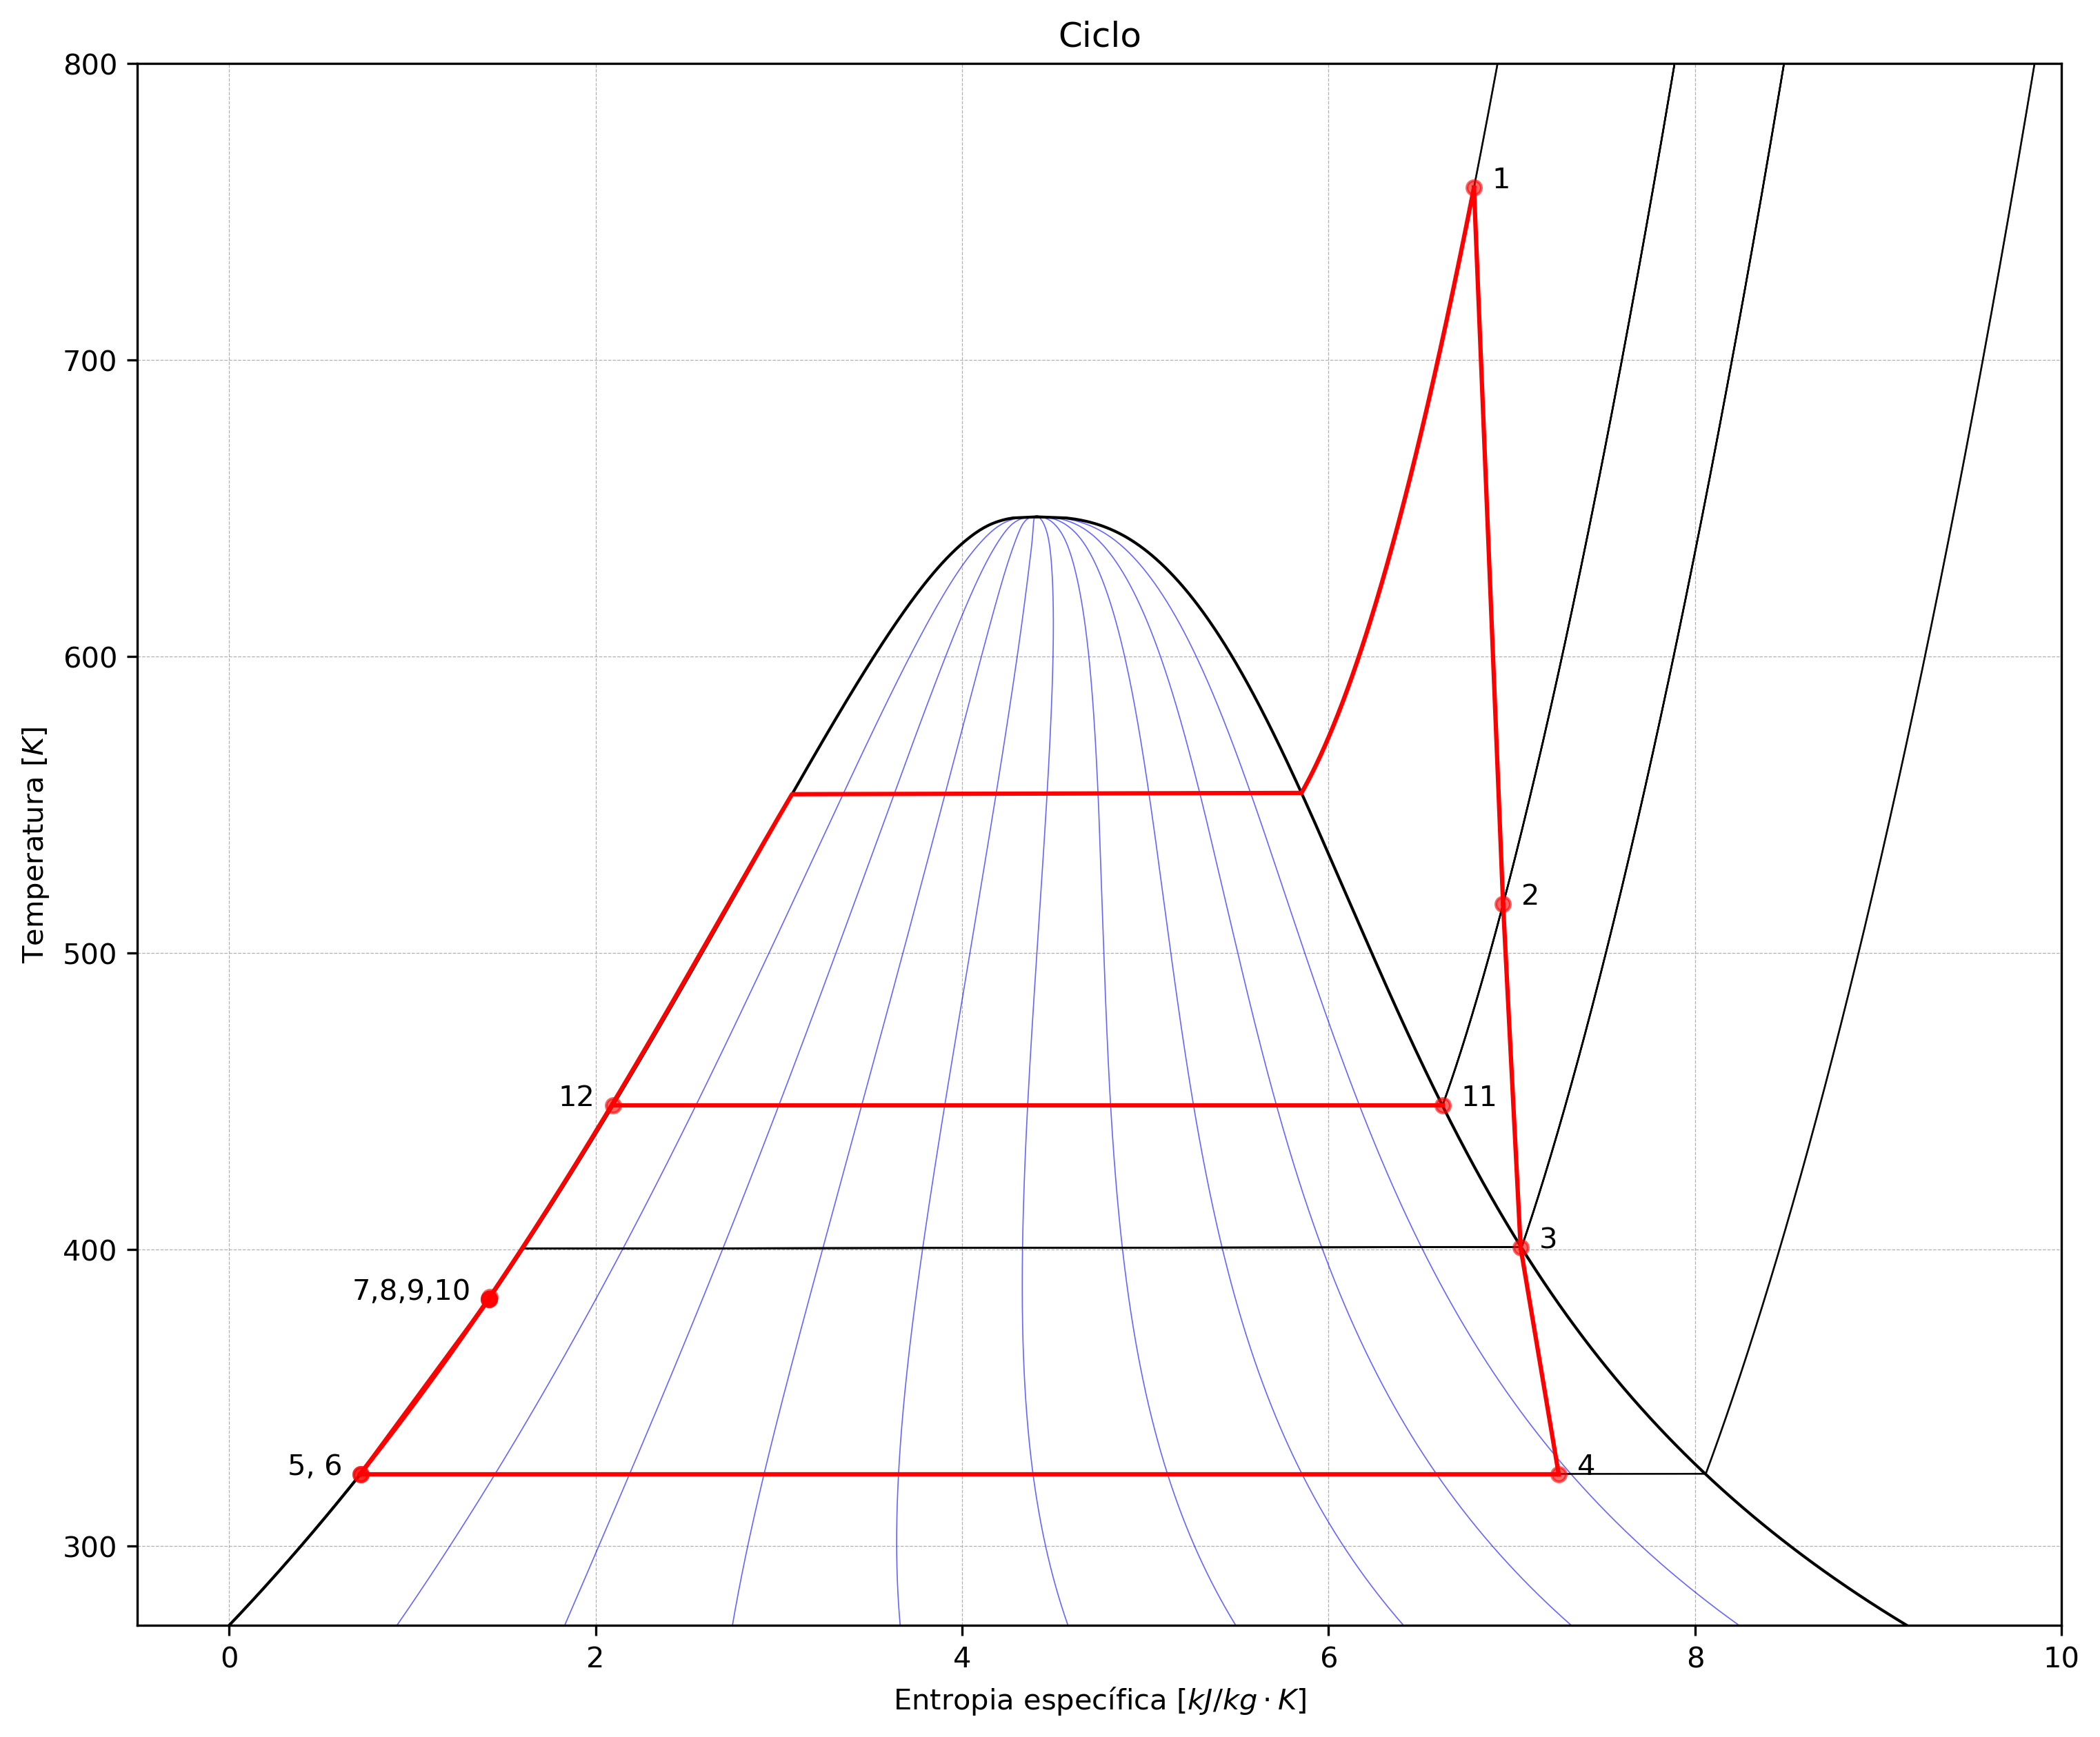

In [123]:
plt.figure(dpi=300, figsize=(12, 10))

#limite dos eixos
plt.ylim(273.15, 800)
plt.xlim(-0.5, 10)

Tmin, Tcrit, Pcrit = prop('Tmin', fluido), prop('Tcrit', fluido), prop('Pcrit', fluido)
T_array = linspace(Tmin, Tcrit, 10**3)

#Linhas de entropia
for c in arange(0.1, 1, 0.1):
  s = prop('S', 'T', T_array, 'Q', c, fluido)/10**3
  plt.plot(s, T_array, color='blue', alpha=0.6, lw=0.4)

#Linhas de pressão constante:
for c in P:
  s = prop('S', 'T', linspace(Tmin, 800, 10**3), 'P', c*10**3, fluido)/10**3
  plt.plot(s, linspace(Tmin, 800, 10**3), color='black',alpha=0.8, lw=0.6)

#Domo:
s = prop('S','T' ,T_array ,'Q',0 ,fluido)/10**3
plt.plot(s, T_array, color='black', lw=1)
s = prop('S', 'T', T_array, 'Q', 1, fluido)/10**3
plt.plot(s, T_array, color='black', lw=1)

#Convertendo temperatura para K
temperatura_k = list(map(lambda x: x+273.15, temperatura)) 

#Inserindo pontos
plt.plot(entropia, temperatura_k, 'ro', markersize=5, alpha=0.6) 

#Ciclo
T_var = linspace(max(temperatura_k), min(temperatura_k), 1000)
s = prop('S','P', P[0]*10**3, 'T',T_var,'Water')/10**3
plt.plot(s,T_var,'r',lw=1.5)

for c in range(len(estados)-3):
    c = c+1
    plt.plot([entropia[c-1], entropia[c]],[temperatura_k[c-1], temperatura_k[c]],color='r',lw=1.5)

plt.plot([entropia[10], entropia[11]],[temperatura_k[10], temperatura_k[11]],color='r',lw=1.5)

#Inserindo nome nos pontos
plt.text(entropia[0]+0.1, temperatura_k[0], '1',ha='left')
plt.text(entropia[1]+0.1, temperatura_k[1], '2',ha='left')
plt.text(entropia[2]+0.1, temperatura_k[2], '3',ha='left')
plt.text(entropia[3]+0.1, temperatura_k[3], '4',ha='left')
plt.text(entropia[4]-0.1, temperatura_k[4], '5, 6',ha='right')
plt.text(entropia[6]-0.1, temperatura_k[6], '7,8,9,10',ha='right')
plt.text(entropia[10]+0.1, temperatura_k[10], '11',ha='left')
plt.text(entropia[11]-0.1, temperatura_k[11], '12',ha='right')

plt.grid(ls='--', lw=0.3)
plt.title('Ciclo')
plt.xlabel(r'Entropia específica $[kJ/kg \cdot K]$')
plt.ylabel(r'Temperatura $[K]$')
plt.show()

[]

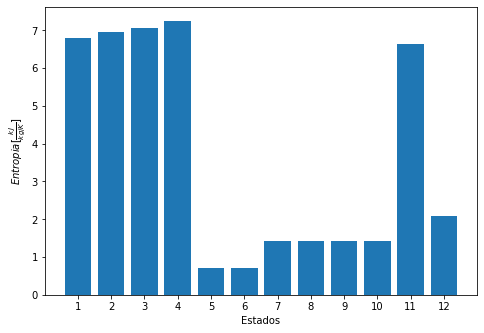

In [115]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(estados, entropia)
ax.set_xticks(estados)
ax.set_xlabel('Estados')
ax.set_ylabel(r'$Entropia [\frac{kJ}{kg/K}]$')
plt.plot()

[]

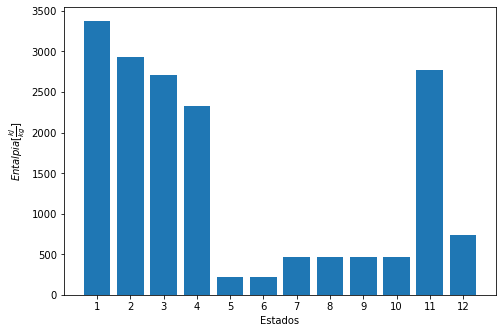

In [116]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(estados, entalpia)
ax.set_xticks(estados)
ax.set_xlabel('Estados')
ax.set_ylabel(r'$Entalpia [\frac{kJ}{kg}]$')
plt.plot()

[]

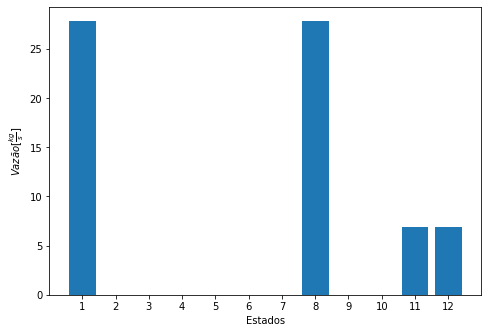

In [117]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(estados, vazao)
ax.set_xticks(estados)
ax.set_xlabel('Estados')
ax.set_ylabel(r'$Vazão [\frac{kg}{s}]$')
plt.plot()

Fazer a modelagem com condensador para que sua temperatura de condensação 
varie conforme a vazão de condensado. Mostrar essa variação.

![Condensador](img/Condensador.jpeg "Condensador")

Desenvolver a análise de primeira lei para o esquema de caldeira abaixo. 
Considerar que este sistema está inserido dentro do ciclo de potência já desenvolvido 
(Fig. 1).


![Caldeira](img/Caldeira.jpeg "Caldeira")